In [3]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import networkx as nx
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GINConv
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import random
import itertools

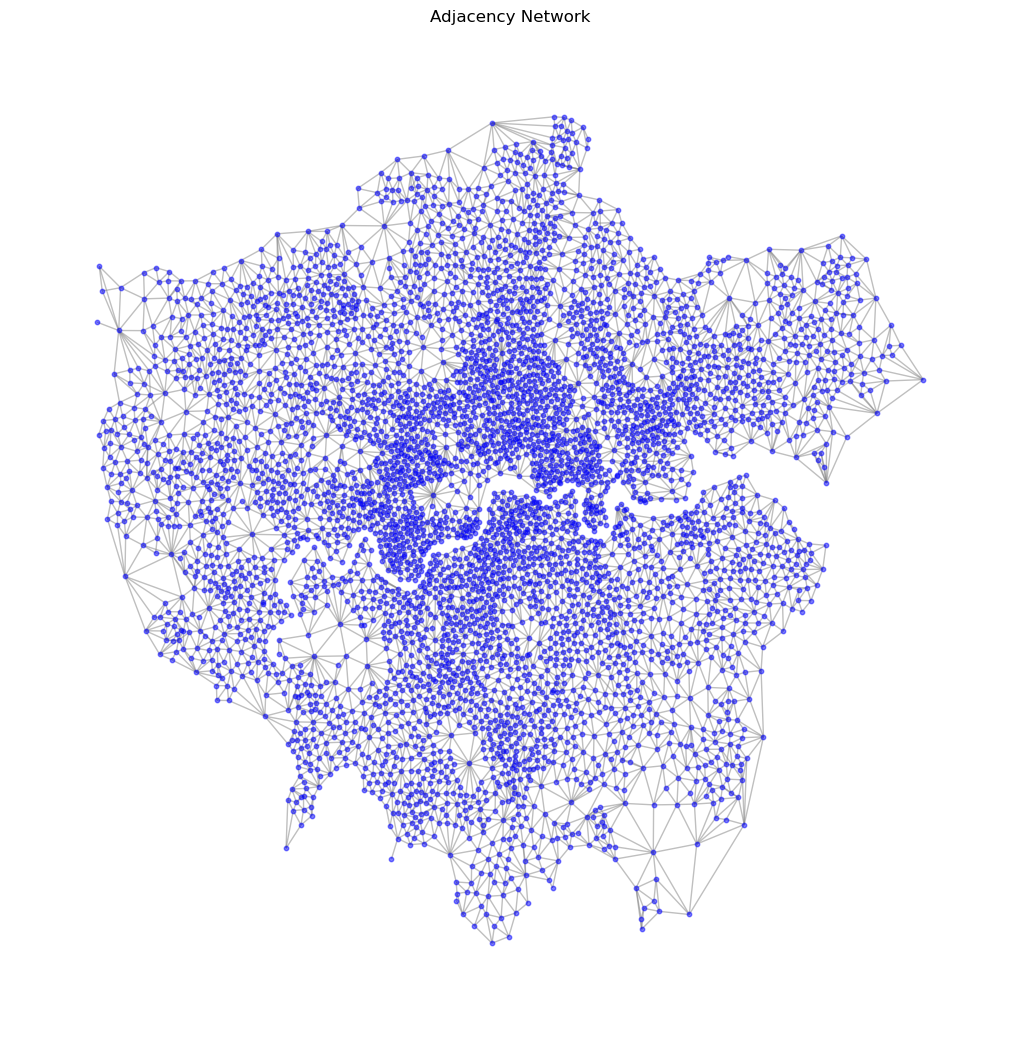

Remaining NaN count per column after filling:
 e_NO2                                       0
e_ndvi                                      0
e_water                                     0
e_trees                                     0
e_grass                                     0
e_bare                                      0
e_built                                     0
e_shrub_and_scrub                           0
e_crops                                     0
e_flooded_vegetation                        0
e_snow_cover                                0
e_evaporation_from_the_top_of_canopy_sum    0
e_surface_runoff_sum                        0
dtype: int64


In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import geopandas as gpd
from shapely import wkt
import pandas as pd
from torch_geometric.utils import from_networkx
import re

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
edges_added = set()
for idx, row in neighbors.iterrows():
    if row.name != row['index_right']:  # 避免自环
        edge = tuple(sorted((row.name, row['index_right'])))
        if edge not in edges_added:
            G.add_edge(row.name, row['index_right'], weight=1)
            edges_added.add(edge)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

# 提取节点特征
node_features = gdf[['e_NO2','e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare','e_built','e_shrub_and_scrub','e_crops','e_flooded_vegetation','e_snow_cover',
                    'e_evaporation_from_the_top_of_canopy_sum','e_surface_runoff_sum']].apply(pd.to_numeric, errors='coerce')

# excluded_e_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# e_features_columns = [col for col in gdf.columns if col.startswith('e_'|'c_') and col not in excluded_e_columns]

# 排除特定列
# excluded_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# 使用正则表达式选择以 e_ 和 c_ 开头的列，并排除特定的列
# selected_columns = [col for col in gdf.columns if (col.startswith('e_') or col.startswith('c_')) and col not in excluded_columns]


# node_features = gdf[selected_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in node_features.iterrows():
    for col in node_features.columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))  # 使用NetworkX图获取邻居索引
            if neighbor_indices:  # 确保有邻居
                neighbor_values = node_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = node_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                node_features.at[i, col] = mean_value
            else:
                node_features.at[i, col] = node_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count per column after filling:\n", node_features.isna().sum())

# 标准化节点特征
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_total_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float)

# 计算边的属性（绝对差值）
edge_attributes = []
edges = []
for u, v in G.edges():
    edge_weight = abs(targets[u].item() - targets[v].item())
    edge_attributes.append(edge_weight)
    edges.append((u, v))

# 转换为PyTorch Geometric数据
data = from_networkx(G)
data.x = node_features_tensor
data.edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data.edge_attr = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)
data.y = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)

Best params: {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 0.8588
MSE: 0.7759
RMSE: 0.8809
MAE: 0.4316
R²: 0.7244


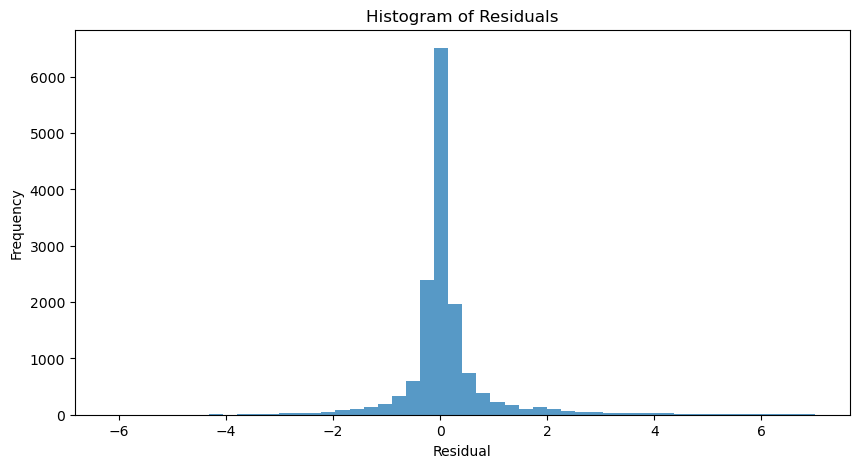

In [30]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
    loss = F.mse_loss(pred_edge_attr, data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 100
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # out_channels should be 1 for regression
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # out_channels should be 1 for regression
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
residuals = y_true - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [31]:
best_params

{'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 64,
 'hidden2': 64,
 'dropout': 0.3,
 'num_epochs': 200}

MSE: 0.7759
RMSE: 0.8809
MAE: 0.4316
R²: 0.7244


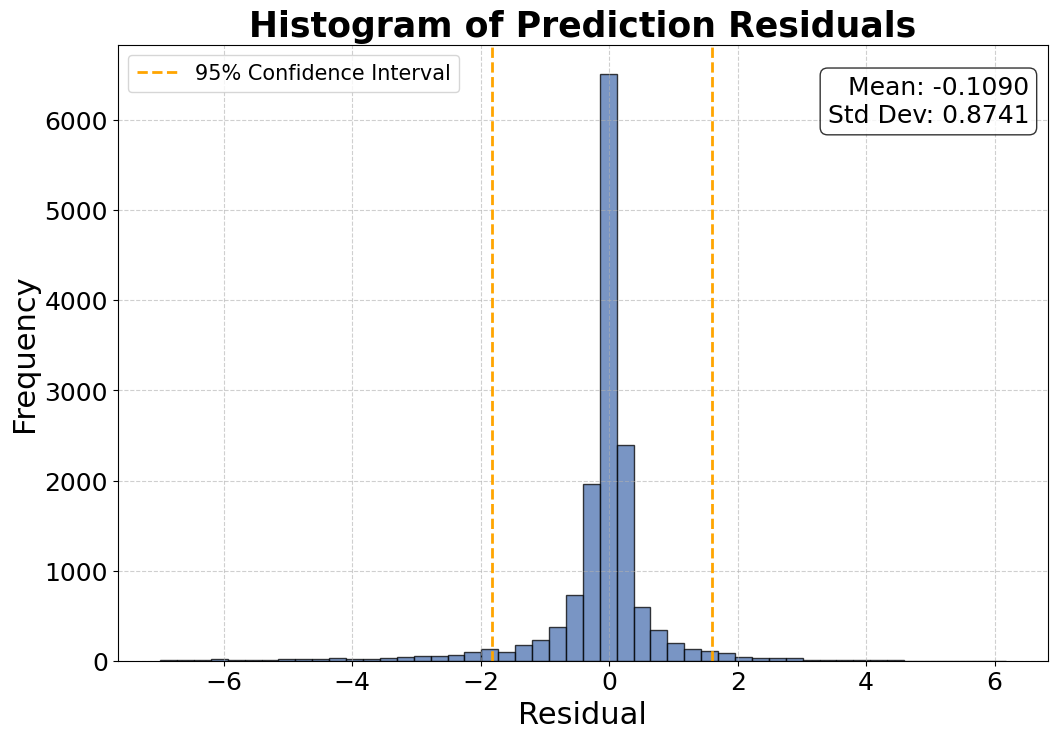

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 评估模型
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 计算残差
residuals_np = y_pred - y_true
mean_residual = np.mean(residuals_np)
std_residual = np.std(residuals_np)

# 绘制残差的直方图
plt.figure(figsize=(12, 8))

# 设置颜色
color = '#4c72b0'
plt.hist(residuals_np, bins=50, alpha=0.75, color=color, edgecolor='black')

# 设置标题和标签
plt.title('Histogram of Prediction Residuals', fontsize=25, weight='bold')
plt.xlabel('Residual', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 添加文本框显示均值和标准差
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.98, 0.95, f'Mean: {mean_residual:.4f}\nStd Dev: {std_residual:.4f}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=18, bbox=props)

# 添加置信区间的线条 (可选)
ci_lower = mean_residual - 1.96 * std_residual
ci_upper = mean_residual + 1.96 * std_residual
plt.axvline(ci_lower, color='orange', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
plt.axvline(ci_upper, color='orange', linestyle='dashed', linewidth=2)

# 添加图例
plt.legend(fontsize=15)

# 确保输出文件夹存在
output_folder = '论文出图'
os.makedirs(output_folder, exist_ok=True)

# 保存图像
output_path = os.path.join(output_folder, '残差图_美化版.png')
plt.savefig(output_path)

# 显示图形
plt.show()


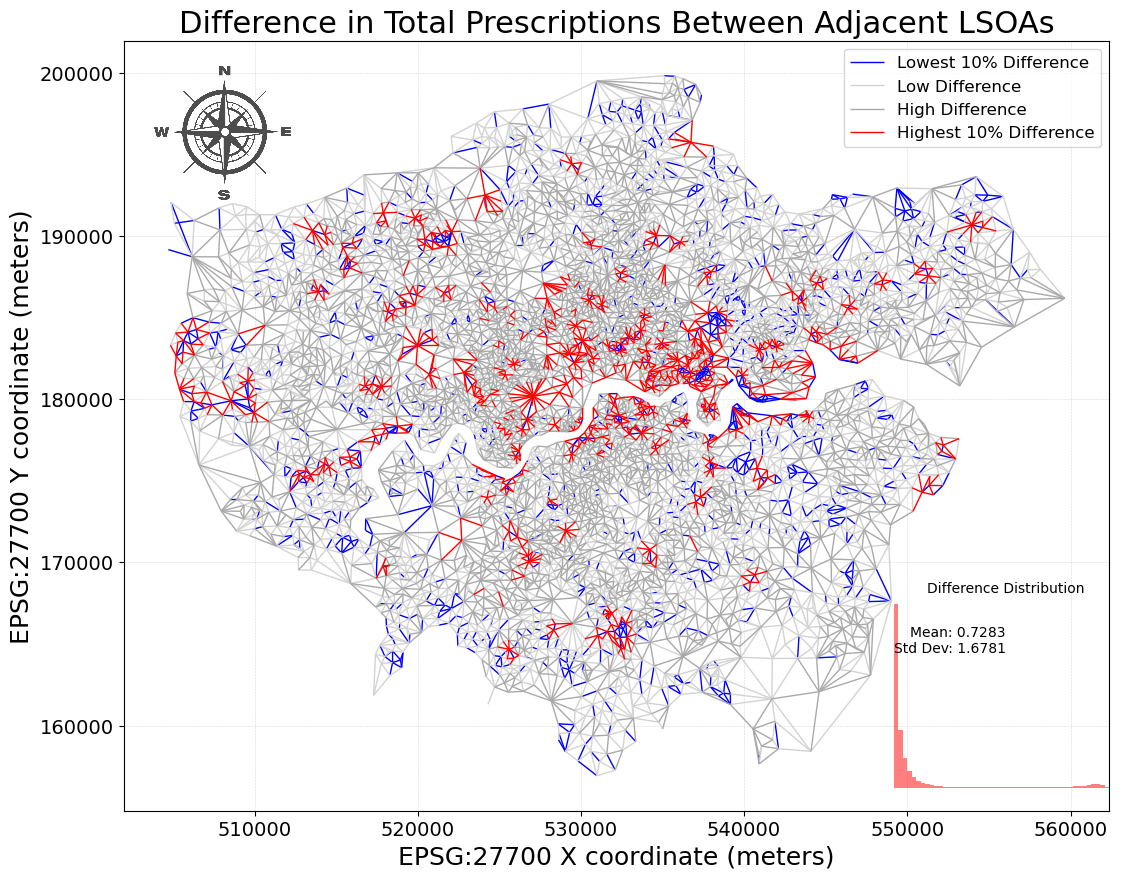

In [52]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 获取边的坐标
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

# 创建 GeoDataFrame 保存边的几何信息
edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 将真实值添加到 GeoDataFrame 中
edge_gdf['true'] = y_true

# 将真实值分为四组
quantiles = np.quantile(edge_gdf['true'], [0, 0.1, 0.5, 0.90, 1.0])
colors = ['blue', 'lightgray', 'darkgray', 'red']
edge_gdf['color'] = pd.cut(edge_gdf['true'], bins=quantiles, labels=colors, include_lowest=True)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据颜色分组绘制边
for color in colors:
    edge_gdf[edge_gdf['color'] == color].plot(ax=ax, color=color, linewidth=1, label=f'{color} group')

# 添加网格
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# 设置坐标轴标签和标题的字体大小
ax.set_xlabel('EPSG:27700 X coordinate (meters)', fontsize=18)
ax.set_ylabel('EPSG:27700 Y coordinate (meters)', fontsize=18)
plt.title("Difference in Total Prescriptions Between Adjacent LSOAs", fontsize=22)

# 添加图例
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], ['Lowest 10% Difference', 
    'Low Difference', 
    'High Difference', 
    'Highest 10% Difference'], fontsize=12)

# 设置坐标轴刻度的字体大小
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# 确保长宽比相等
ax.set_aspect('equal')

# 添加指北针
north_arrow_path = "north arrow.png"  # 替换为你的指北针图片路径
arr_img = plt.imread(north_arrow_path)
imagebox = OffsetImage(arr_img, zoom=0.1, alpha=0.7)  # 调整缩放比例
ab = AnnotationBbox(imagebox, (0.1, 0.88), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

# 插入边属性的直方图作为子图，位于右下角
ax_inset = inset_axes(ax, width="25%", height="25%", loc="lower right", 
                      bbox_to_anchor=(0.02, 0.03, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
edge_true_values = edge_gdf['true'].dropna()  # 排除NaN值
mean_value = edge_true_values.mean()
std_value = edge_true_values.std()

ax_inset.hist(edge_true_values, bins=50, alpha=0.5, color='red')  # 直方图颜色为红色
ax_inset.set_title('Difference Distribution', fontsize=10, pad=0)
ax_inset.axis('off')  # 移除坐标轴框和标签

# 在子图中添加均值和标准差的文本
ax_inset.text(0.5, 0.7, f'Mean: {mean_value:.4f}\nStd Dev: {std_value:.4f}', 
              horizontalalignment='right', verticalalignment='baseline', 
              transform=ax_inset.transAxes, fontsize=10, color='black')

# Ensure the output folder exists
output_folder = '论文出图'
os.makedirs(output_folder, exist_ok=True)

# Save the plot to the output folder
output_path = os.path.join(output_folder, '真实边属性图.png')
plt.savefig(output_path)

plt.show()


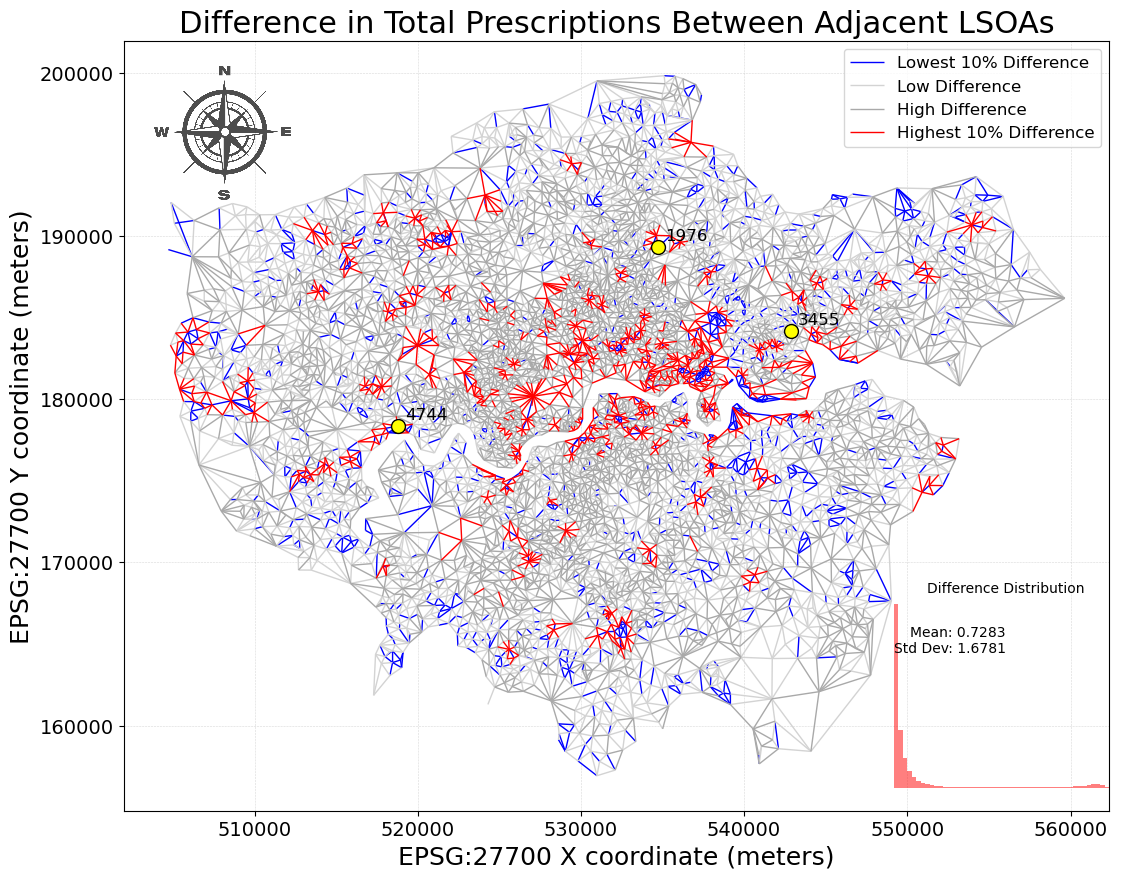

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import pandas as pd
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 提取边的坐标并创建 GeoDataFrame
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 将真实值（边属性）添加到 GeoDataFrame 中
edge_gdf['true'] = data.y.numpy().flatten()

# 将真实值分为四组
quantiles = np.quantile(edge_gdf['true'], [0, 0.1, 0.5, 0.90, 1.0])
colors = ['blue', 'lightgray', 'darkgray', 'red']
edge_gdf['color'] = pd.cut(edge_gdf['true'], bins=quantiles, labels=colors, include_lowest=True)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据颜色分组绘制边
for color in colors:
    edge_gdf[edge_gdf['color'] == color].plot(ax=ax, color=color, linewidth=1, label=f'{color} group')

# 添加网格
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# 设置坐标轴标签和标题的字体大小
ax.set_xlabel('EPSG:27700 X coordinate (meters)', fontsize=18)
ax.set_ylabel('EPSG:27700 Y coordinate (meters)', fontsize=18)
plt.title("Difference in Total Prescriptions Between Adjacent LSOAs", fontsize=22)

# 添加图例
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], ['Lowest 10% Difference', 
    'Low Difference', 
    'High Difference', 
    'Highest 10% Difference'], fontsize=12)

# 设置坐标轴刻度的字体大小
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# 确保长宽比相等
ax.set_aspect('equal')

# 绘制并标注指定的节点
highlighted_nodes = [1976, 4744, 3455]
for node in highlighted_nodes:
    node_pos = G.nodes[node]['pos']
    ax.scatter(*node_pos, color='yellow', s=100, edgecolor='black', zorder=5)  # 绘制节点
    ax.annotate(str(node), xy=node_pos, xytext=(5, 5), textcoords='offset points', fontsize=12, color='black')

# 添加指北针
north_arrow_path = "north arrow.png"  # 替换为你的指北针图片路径
arr_img = plt.imread(north_arrow_path)
imagebox = OffsetImage(arr_img, zoom=0.1, alpha=0.7)  # 调整缩放比例
ab = AnnotationBbox(imagebox, (0.1, 0.88), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

# 插入边属性的直方图作为子图，位于右下角
ax_inset = inset_axes(ax, width="25%", height="25%", loc="lower right", 
                      bbox_to_anchor=(0.02, 0.03, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
edge_true_values = edge_gdf['true'].dropna()  # 排除NaN值
mean_value = edge_true_values.mean()
std_value = edge_true_values.std()

ax_inset.hist(edge_true_values, bins=50, alpha=0.5, color='red')  # 直方图颜色为红色
ax_inset.set_title('Difference Distribution', fontsize=10, pad=0)
ax_inset.axis('off')  # 移除坐标轴框和标签

# 在子图中添加均值和标准差的文本
ax_inset.text(0.5, 0.7, f'Mean: {mean_value:.4f}\nStd Dev: {std_value:.4f}', 
              horizontalalignment='right', verticalalignment='baseline', 
              transform=ax_inset.transAxes, fontsize=10, color='black')

# Ensure the output folder exists
output_folder = '论文出图'
os.makedirs(output_folder, exist_ok=True)

# Save the plot to the output folder
output_path = os.path.join(output_folder, '真实边属性图.png')
plt.savefig(output_path)

plt.show()


       avg_edge_value
count     4994.000000
mean         3.316488
std          2.969320
min          0.000000
25%          1.334719
50%          2.561342
75%          4.355785
max         30.351424


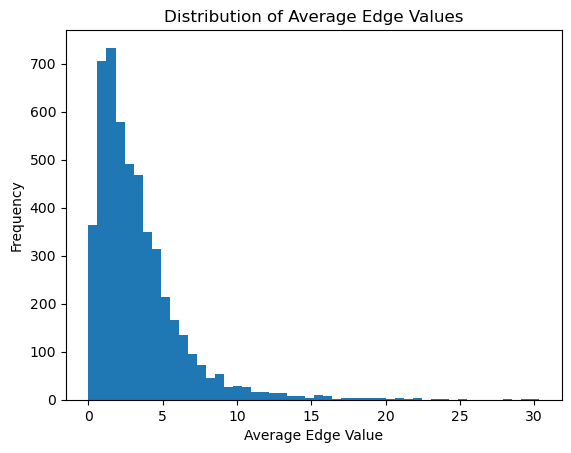

Quantiles: [ 0.          0.72633251  2.56134151  6.58294378 30.35142365]


{'high_value_nodes': [4575,
  4708,
  779,
  1077,
  4917,
  4929,
  4645,
  427,
  3894,
  1591],
 'low_value_nodes': [3392, 3632, 829, 908, 4943, 4954, 3419, 610, 2765, 1040],
 'medium_value_nodes': [1447,
  4082,
  1873,
  1583,
  4199,
  1503,
  1778,
  986,
  4495,
  2106]}

In [69]:
import networkx as nx
import numpy as np
import pandas as pd

# 假设 G 是已经构建好的图，edge_gdf 包含边的属性

# 创建字典从 edge_gdf 中获取每条边的 'true' 值
edge_true_values = {}
for idx, row in edge_gdf.iterrows():
    edge_true_values[(row.geometry.coords[0], row.geometry.coords[1])] = row['true']
    edge_true_values[(row.geometry.coords[1], row.geometry.coords[0])] = row['true']

# 将 'true' 值附加到图的边属性中
for u, v, data in G.edges(data=True):
    if (G.nodes[u]['pos'], G.nodes[v]['pos']) in edge_true_values:
        data['true'] = edge_true_values[(G.nodes[u]['pos'], G.nodes[v]['pos'])]
    elif (G.nodes[v]['pos'], G.nodes[u]['pos']) in edge_true_values:
        data['true'] = edge_true_values[(G.nodes[v]['pos'], G.nodes[u]['pos'])]

# 计算每个节点的平均边值
node_avg_edge_values = {}
for node in G.nodes:
    edge_values = []
    for neighbor in G.neighbors(node):
        edge_data = G.get_edge_data(node, neighbor)
        if 'true' in edge_data:
            edge_values.append(edge_data['true'])
    node_avg_edge_values[node] = np.mean(edge_values) if edge_values else 0

# 将节点分为高值、低值和普通
node_df = pd.DataFrame.from_dict(node_avg_edge_values, orient='index', columns=['avg_edge_value'])

# 打印平均边值的分布情况
print(node_df.describe())

# 绘制平均边值的直方图
plt.hist(node_df['avg_edge_value'], bins=50)
plt.title('Distribution of Average Edge Values')
plt.xlabel('Average Edge Value')
plt.ylabel('Frequency')
plt.show()

# 计算分位点并检查是否有重复的分位点
quantiles = np.quantile(node_df['avg_edge_value'], [0, 0.1, 0.5, 0.9, 1.0])
unique_quantiles = np.unique(quantiles)
print("Quantiles:", quantiles)

# 如果分位点过少，则直接使用值分类
if len(unique_quantiles) < 4:
    low_threshold = np.percentile(node_df['avg_edge_value'], 10)
    high_threshold = np.percentile(node_df['avg_edge_value'], 90)
    
    def categorize(value):
        if value <= low_threshold:
            return 'low'
        elif value >= high_threshold:
            return 'high'
        else:
            return 'medium'
    
    node_df['category'] = node_df['avg_edge_value'].apply(categorize)
else:
    node_df['category'] = pd.cut(node_df['avg_edge_value'], bins=quantiles, labels=['low', 'medium_low', 'medium', 'high'], include_lowest=True)

# 检查每个类别中的节点数量并进行抽样
def sample_nodes(df, category, n):
    nodes = df[df['category'] == category]
    if len(nodes) < n:
        return nodes.index.tolist()
    return nodes.sample(n=n, random_state=1).index.tolist()

high_value_nodes = sample_nodes(node_df, 'high', 10)
low_value_nodes = sample_nodes(node_df, 'low', 10)
medium_value_nodes = sample_nodes(node_df, 'medium', 10)

selected_nodes = {
    'high_value_nodes': high_value_nodes,
    'low_value_nodes': low_value_nodes,
    'medium_value_nodes': medium_value_nodes
}

selected_nodes

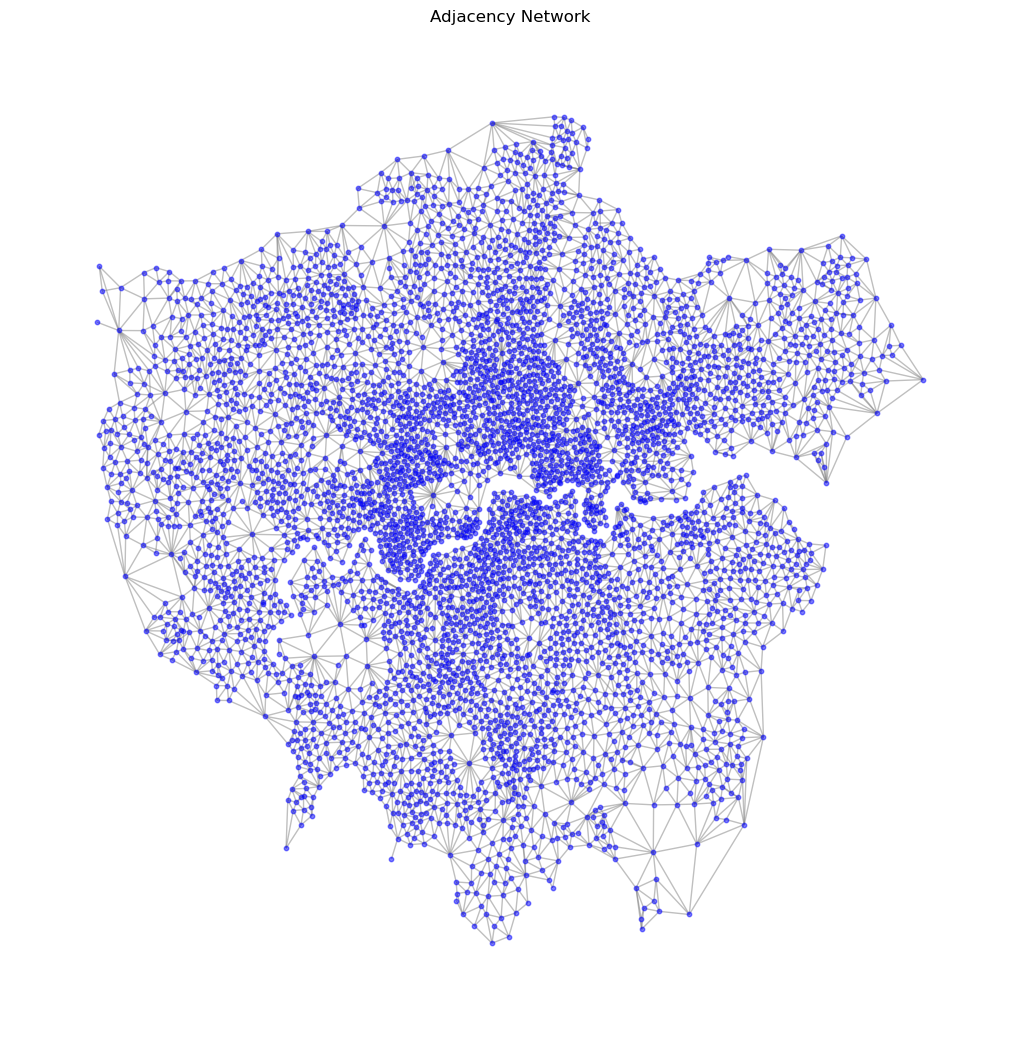

Remaining NaN count per column after filling:
 e_NO2                                       0
e_ndvi                                      0
e_water                                     0
e_trees                                     0
e_grass                                     0
e_bare                                      0
e_built                                     0
e_shrub_and_scrub                           0
e_crops                                     0
e_flooded_vegetation                        0
e_snow_cover                                0
e_evaporation_from_the_top_of_canopy_sum    0
e_surface_runoff_sum                        0
dtype: int64


In [70]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import geopandas as gpd
from shapely import wkt
import pandas as pd
from torch_geometric.utils import from_networkx
import re

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
edges_added = set()
for idx, row in neighbors.iterrows():
    if row.name != row['index_right']:  # 避免自环
        edge = tuple(sorted((row.name, row['index_right'])))
        if edge not in edges_added:
            G.add_edge(row.name, row['index_right'], weight=1)
            edges_added.add(edge)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

# 提取节点特征
node_features = gdf[['e_NO2','e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare','e_built','e_shrub_and_scrub','e_crops','e_flooded_vegetation','e_snow_cover',
                    'e_evaporation_from_the_top_of_canopy_sum','e_surface_runoff_sum']].apply(pd.to_numeric, errors='coerce')

# excluded_e_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# e_features_columns = [col for col in gdf.columns if col.startswith('e_'|'c_') and col not in excluded_e_columns]

# 排除特定列
# excluded_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# 使用正则表达式选择以 e_ 和 c_ 开头的列，并排除特定的列
# selected_columns = [col for col in gdf.columns if (col.startswith('e_') or col.startswith('c_')) and col not in excluded_columns]


# node_features = gdf[selected_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in node_features.iterrows():
    for col in node_features.columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))  # 使用NetworkX图获取邻居索引
            if neighbor_indices:  # 确保有邻居
                neighbor_values = node_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = node_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                node_features.at[i, col] = mean_value
            else:
                node_features.at[i, col] = node_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count per column after filling:\n", node_features.isna().sum())

# 标准化节点特征
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_total_quantity_per_capita'
# target_column = 'o_depression_quantity_per_capita'

target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float)

# 计算边的属性（绝对差值）
edge_attributes = []
edges = []
for u, v in G.edges():
    edge_weight = abs(targets[u].item() - targets[v].item())
    edge_attributes.append(edge_weight)
    edges.append((u, v))

# 转换为PyTorch Geometric数据
data = from_networkx(G)
data.x = node_features_tensor
data.edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data.edge_attr = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)
data.y = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)

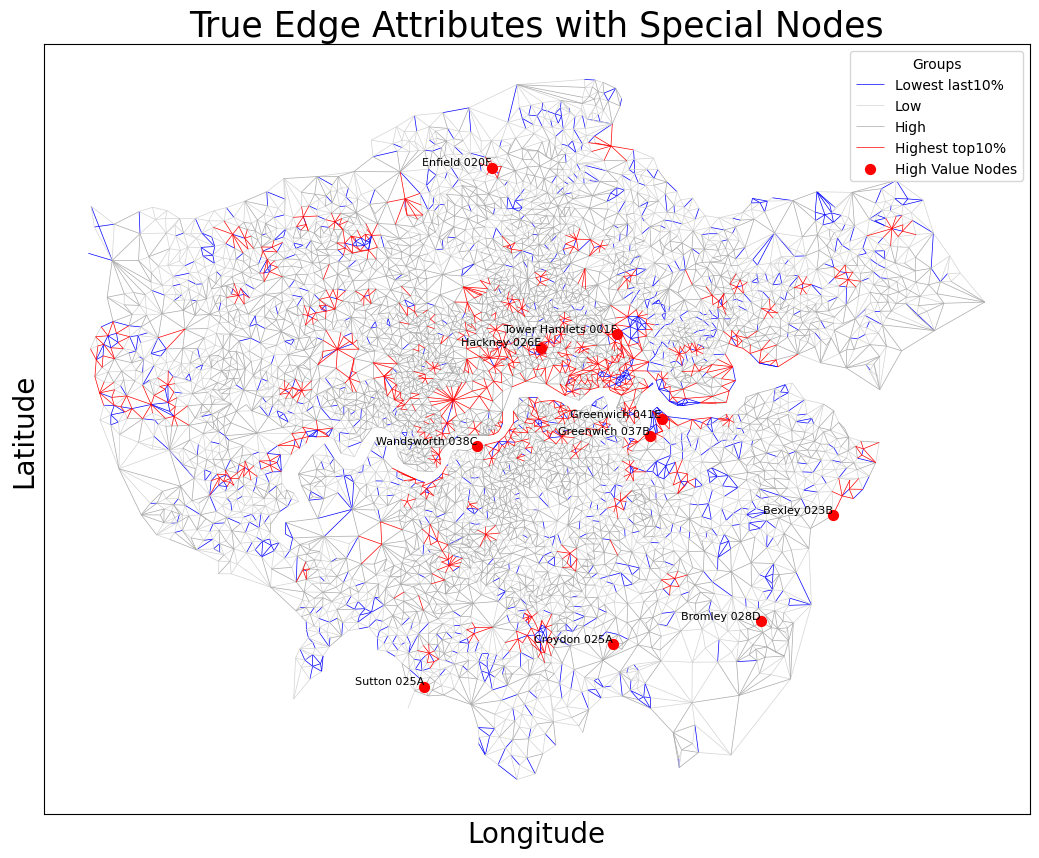

High Value Nodes Names:
{4575: 'Wandsworth 038C', 4708: 'Enfield 020F', 779: 'Bromley 028D', 1077: 'Croydon 025A', 4917: 'Hackney 026E', 4929: 'Tower Hamlets 001F', 4645: 'Greenwich 041E', 427: 'Bexley 023B', 3894: 'Sutton 025A', 1591: 'Greenwich 037B'}
Low Value Nodes Names:
{3392: 'Newham 008A', 3632: 'Richmond upon Thames 005D', 829: 'Camden 015D', 908: 'Camden 023E', 4943: 'Tower Hamlets 012G', 4954: 'Tower Hamlets 019H', 3419: 'Newham 002D', 610: 'Brent 022C', 2765: 'Kensington and Chelsea 003E', 1040: 'Croydon 004C'}
Medium Value Nodes Names:
{1447: 'Enfield 012B', 4082: 'Tower Hamlets 006A', 1873: 'Haringey 004D', 1583: 'Greenwich 029B', 4199: 'Waltham Forest 023E', 1503: 'Enfield 022B', 1778: 'Hammersmith and Fulham 001C', 986: 'Croydon 035A', 4495: 'Westminster 022D', 2106: 'Harrow 031B'}


In [71]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

# 获取节点名称
node_names = {idx: row['LSOA21NM'] for idx, row in gdf.iterrows()}

# 获取特殊节点的名称
high_value_node_names = {node: node_names[node] for node in high_value_nodes}
low_value_node_names = {node: node_names[node] for node in low_value_nodes}
medium_value_node_names = {node: node_names[node] for node in medium_value_nodes}

# 获取边的坐标
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

# 创建 GeoDataFrame 保存边的几何信息
edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 确保 data 对象存在且具有 y 属性
if isinstance(data, Data) and hasattr(data, 'y'):
    edge_gdf['true'] = data.y.numpy()
else:
    raise AttributeError("data object is not a PyTorch Geometric Data object with attribute 'y'.")

# 将真实值分为四组
quantiles = np.quantile(edge_gdf['true'], [0, 0.1, 0.5, 0.90, 1.0])
colors = ['blue', 'lightgray', 'darkgray', 'red']
edge_gdf['color'] = pd.cut(edge_gdf['true'], bins=quantiles, labels=colors, include_lowest=True)

# 从data中获取节点位置
pos = {i: (data.pos[i][0].item(), data.pos[i][1].item()) for i in range(data.pos.shape[0])}

# 创建绘图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据颜色分组绘制边
for color in colors:
    edge_gdf[edge_gdf['color'] == color].plot(ax=ax, color=color, linewidth=0.5, label=f'{color} group')

# 绘制节点位置
nx.draw_networkx_nodes(G, pos, nodelist=high_value_nodes, node_size=50, node_color='red', label='High Value Nodes', ax=ax)

# 添加节点名称，偏移标签位置
for node, (x, y) in pos.items():
    if node in high_value_node_names:
        ax.text(x, y, high_value_node_names[node], fontsize=8, color='black', ha='right', va='bottom')

# 添加图例项
high_node_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Value Nodes')
ax.legend(handles=ax.get_legend_handles_labels()[0] + [high_node_legend],
          labels=['Lowest last10%', 'Low', 'High', 'Highest top10%', 'High Value Nodes'], title='Groups')

# 设置标题和坐标轴标签
plt.title("True Edge Attributes with Special Nodes", fontsize=25)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)

# 设置刻度显示
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# 手动设置刻度
xticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=10)
yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], num=10)

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels([f'{tick:.2f}' for tick in xticks], fontsize=18)
ax.set_yticklabels([f'{tick:.2f}' for tick in yticks], fontsize=18)

# 设置长宽比
ax.set_aspect('equal')

plt.show()

# 打印特殊节点的名称
print("High Value Nodes Names:")
print(high_value_node_names)
print("Low Value Nodes Names:")
print(low_value_node_names)
print("Medium Value Nodes Names:")
print(medium_value_node_names)
